In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import folium

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,16)})
sns.set_theme(style="whitegrid")

In [3]:
comuni_geo = "Downloads/italy_geo.xlsx"
comuni_reg = "Downloads/italy_cities.xlsx"

In [4]:
df_geo = pd.read_excel(comuni_geo, skipfooter=1)
df_geo

istat           comune       lng        lat
0       1001            Agliè  7.768600  45.363433
1       1002          Airasca  7.484431  44.916886
2       1003     Ala di Stura  7.304344  45.315110
3       1004  Albiano d'Ivrea  7.949145  45.433893
4       1005  Alice Superiore  7.777019  45.460094
...      ...              ...       ...        ...
7973  111103       Villaputzu  9.574832  39.440086
7974  111104       Villasalto  9.388774  39.493758
7975  111105      Villasimius  9.520365  39.142384
7976  111106         Villasor  8.940650  39.380689
7977  111107    Villaspeciosa  8.926934  39.312805

[7978 rows x 4 columns]

In [5]:
df_reg = pd.read_excel(comuni_reg, skipfooter=1)
df_reg.drop(columns=["prefisso", "cod_fisco", "superficie", "num_residenti"], axis=1, inplace=True)
df_reg

istat           comune   regione provincia
0       1001            Agliè  Piemonte        TO
1       1002          Airasca  Piemonte        TO
2       1003     Ala di Stura  Piemonte        TO
3       1004  Albiano d'Ivrea  Piemonte        TO
4       1005  Alice Superiore  Piemonte        TO
...      ...              ...       ...       ...
7973  111103       Villaputzu  Sardegna        SU
7974  111104       Villasalto  Sardegna        SU
7975  111105      Villasimius  Sardegna        SU
7976  111106         Villasor  Sardegna        SU
7977  111107    Villaspeciosa  Sardegna        SU

[7978 rows x 4 columns]

In [6]:
df = pd.merge(df_geo, df_reg, on=["istat", "comune"])
df.rename(columns={"comune" : "town", "regione": "region", "provincia": "province"}, inplace=True)
df

istat             town       lng        lat    region province
0       1001            Agliè  7.768600  45.363433  Piemonte       TO
1       1002          Airasca  7.484431  44.916886  Piemonte       TO
2       1003     Ala di Stura  7.304344  45.315110  Piemonte       TO
3       1004  Albiano d'Ivrea  7.949145  45.433893  Piemonte       TO
4       1005  Alice Superiore  7.777019  45.460094  Piemonte       TO
...      ...              ...       ...        ...       ...      ...
7938  111103       Villaputzu  9.574832  39.440086  Sardegna       SU
7939  111104       Villasalto  9.388774  39.493758  Sardegna       SU
7940  111105      Villasimius  9.520365  39.142384  Sardegna       SU
7941  111106         Villasor  8.940650  39.380689  Sardegna       SU
7942  111107    Villaspeciosa  8.926934  39.312805  Sardegna       SU

[7943 rows x 6 columns]

### Clean up names

In [7]:
df["region"].replace(to_replace="Emilia-ROmagna", value="Emilia-Romagna", inplace=True)

In [8]:
chars = {
         " " : "",
         "'" : "",
         "à" : "a",
         "è" : "e",
         "é" : "e",
         "ì" : "i",
         "ù" : "u"
        }
df["Name"] = df["town"].replace(chars, regex=True).str.upper()
df["Name"]

0                AGLIE
1              AIRASCA
2           ALADISTURA
3        ALBIANODIVREA
4       ALICESUPERIORE
             ...      
7938        VILLAPUTZU
7939        VILLASALTO
7940       VILLASIMIUS
7941          VILLASOR
7942     VILLASPECIOSA
Name: Name, Length: 7943, dtype: object

### Generate prefixes and suffixes

In [9]:
df["Prefix"] = df["Name"].str[:3:] + "-"
df["Suffix"] = "-" + df["Name"].str[-3::]

df.head()

istat             town       lng        lat    region province  \
0   1001            Agliè  7.768600  45.363433  Piemonte       TO   
1   1002          Airasca  7.484431  44.916886  Piemonte       TO   
2   1003     Ala di Stura  7.304344  45.315110  Piemonte       TO   
3   1004  Albiano d'Ivrea  7.949145  45.433893  Piemonte       TO   
4   1005  Alice Superiore  7.777019  45.460094  Piemonte       TO   

             Name Prefix Suffix  
0           AGLIE   AGL-   -LIE  
1         AIRASCA   AIR-   -SCA  
2      ALADISTURA   ALA-   -URA  
3   ALBIANODIVREA   ALB-   -REA  
4  ALICESUPERIORE   ALI-   -ORE

### Find 10 most common prefixes

In [10]:
prefix = df["Prefix"].value_counts().head(10)
prf = prefix.index.tolist()
prf = sorted(prf)
prf

['CAM-',
 'CAR-',
 'CAS-',
 'MAR-',
 'MON-',
 'ROC-',
 'SAN-',
 'TOR-',
 'VAL-',
 'VIL-']

### Find 10 most common suffixes

In [11]:
suffix = df["Suffix"].value_counts().head(10)
suf = suffix.index.tolist()
suf = sorted(suf)
suf

['-ANA',
 '-ANO',
 '-ESE',
 '-INA',
 '-INO',
 '-LLO',
 '-OLA',
 '-OLO',
 '-ONE',
 '-ORE']

### Associate color palette for the map

In [12]:
colors = ["violet", "darkblue", "blue", "lightblue", "darkgreen", "green", "lightgreen", "yellow", "orange", "red"]
colors_prf = dict(zip(prf, colors))
colors_suf = dict(zip(suf, colors))

In [13]:
df_prf = df[df["Prefix"].isin(prf)]
df_prf["Color"] = df_prf["Prefix"].map(colors_prf)
df_prf

<ipython-input-13-d58acebd1420>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["Color"] = df_prf["Prefix"].map(colors_prf)


istat                town       lng        lat    region province  \
47      1048            Cambiano  7.779325  44.973460  Piemonte       TO   
48      1049  Campiglione Fenile  7.325038  44.802124  Piemonte       TO   
55      1056            Caravino  7.960214  45.398605  Piemonte       TO   
56      1057              Carema  7.812304  45.584447  Piemonte       TO   
57      1058           Carignano  7.675343  44.906667  Piemonte       TO   
...      ...                 ...       ...        ...       ...      ...   
7938  111103          Villaputzu  9.574832  39.440086  Sardegna       SU   
7939  111104          Villasalto  9.388774  39.493758  Sardegna       SU   
7940  111105         Villasimius  9.520365  39.142384  Sardegna       SU   
7941  111106            Villasor  8.940650  39.380689  Sardegna       SU   
7942  111107       Villaspeciosa  8.926934  39.312805  Sardegna       SU   

                   Name Prefix Suffix     Color  
47             CAMBIANO   CAM-   -ANO    violet  
48    CAMPIGLIONEFENILE   CAM-   -ILE    violet  
55             CARAVINO   CAR-   -INO  darkblue  
56               CAREMA   CAR-   -EMA  darkblue  
57            CARIGNANO   CAR-   -ANO  darkblue  
...                 ...    ...    ...       ...  
7938         VILLAPUTZU   VIL-   -TZU       red  
7939         VILLASALTO   VIL-   -LTO       red  
7940        VILLASIMIUS   VIL-   -IUS       red  
7941           VILLASOR   VIL-   -SOR       red  
7942      VILLASPECIOSA   VIL-   -OSA       red  

[1886 rows x 10 columns]

In [14]:
df_suf = df[df["Suffix"].isin(suf)]
df_suf["Color"] = df["Suffix"].map(colors_suf)
df_suf

<ipython-input-14-79b431af174b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suf["Color"] = df["Suffix"].map(colors_suf)


istat             town       lng        lat    region province  \
4       1005  Alice Superiore  7.777019  45.460094  Piemonte       TO   
5       1006           Almese  7.395182  45.117663  Piemonte       TO   
7       1008        Alpignano  7.524267  45.094470  Piemonte       TO   
11      1012         Arignano  7.902446  45.044029  Piemonte       TO   
12      1013        Avigliana  7.396323  45.079357  Piemonte       TO   
...      ...              ...       ...        ...       ...      ...   
7853  111018      Escalaplano  9.355094  39.626279  Sardegna       SU   
7856  111021  Fluminimaggiore  8.497865  39.436402  Sardegna       SU   
7867  111032      Guamaggiore  9.073536  39.566788  Sardegna       SU   
7911  111076         Serdiana  9.156920  39.373543  Sardegna       SU   
7928  111093           Ussana  9.077708  39.392748  Sardegna       SU   

                 Name Prefix Suffix     Color  
4      ALICESUPERIORE   ALI-   -ORE       red  
5              ALMESE   ALM-   -ESE      blue  
7           ALPIGNANO   ALP-   -ANO  darkblue  
11           ARIGNANO   ARI-   -ANO  darkblue  
12          AVIGLIANA   AVI-   -ANA    violet  
...               ...    ...    ...       ...  
7853      ESCALAPLANO   ESC-   -ANO  darkblue  
7856  FLUMINIMAGGIORE   FLU-   -ORE       red  
7867      GUAMAGGIORE   GUA-   -ORE       red  
7911         SERDIANA   SER-   -ANA    violet  
7928           USSANA   USS-   -ANA    violet  

[2100 rows x 10 columns]

In [39]:
m_prf = folium.Map(location=[42, 12], zoom_start=6, tiles="cartodb positron")

for grp_name, df_grp in df_prf.groupby("Prefix"):
    feature_group = folium.FeatureGroup(grp_name)
    for row in df_grp.itertuples():
        legend = str(row.town) + " (" + str(row.province) + ")"
        folium.Circle(location=[row.lat, row.lng], popup=legend, radius=1000, color=row.Color).add_to(feature_group)
    feature_group.add_to(m_prf)

folium.LayerControl().add_to(m_prf)
m_prf

In [16]:
m_suf = folium.Map(location=[42, 12], zoom_start=6, tiles="cartodb positron")

for grp_name, df_grp in df_suf.groupby("Suffix"):
    feature_group = folium.FeatureGroup(grp_name)
    for row in df_grp.itertuples():
        legend = str(row.town) + " (" + str(row.province) + ")"
        folium.Circle(location=[row.lat, row.lng], popup=legend, radius=1000, color=row.Color).add_to(feature_group)
    feature_group.add_to(m_suf)

folium.LayerControl().add_to(m_suf)
m_suf

In [17]:
m_prf.save("ITA_prefixes.html")
m_suf.save("ITA_suffixes.html")

<AxesSubplot:xlabel='Suffix', ylabel='lat'>

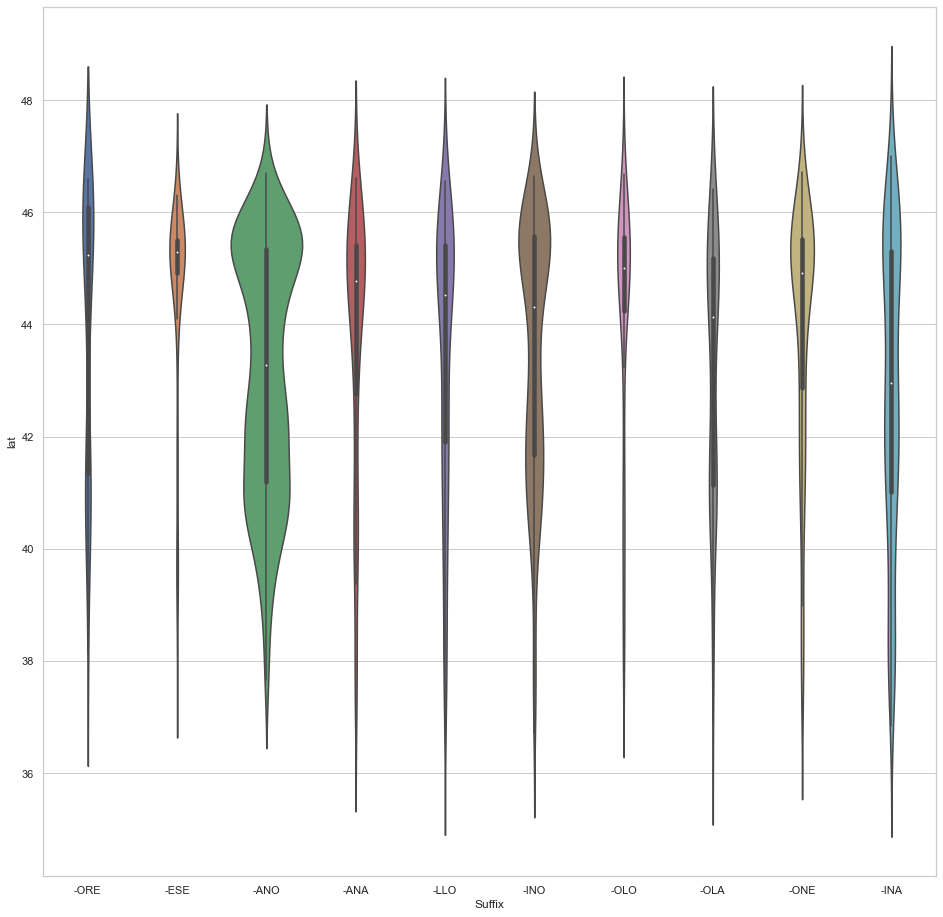

In [18]:
sns.violinplot(x="Suffix", y="lat", scale="count", data=df_suf)

<AxesSubplot:xlabel='lng', ylabel='Suffix'>

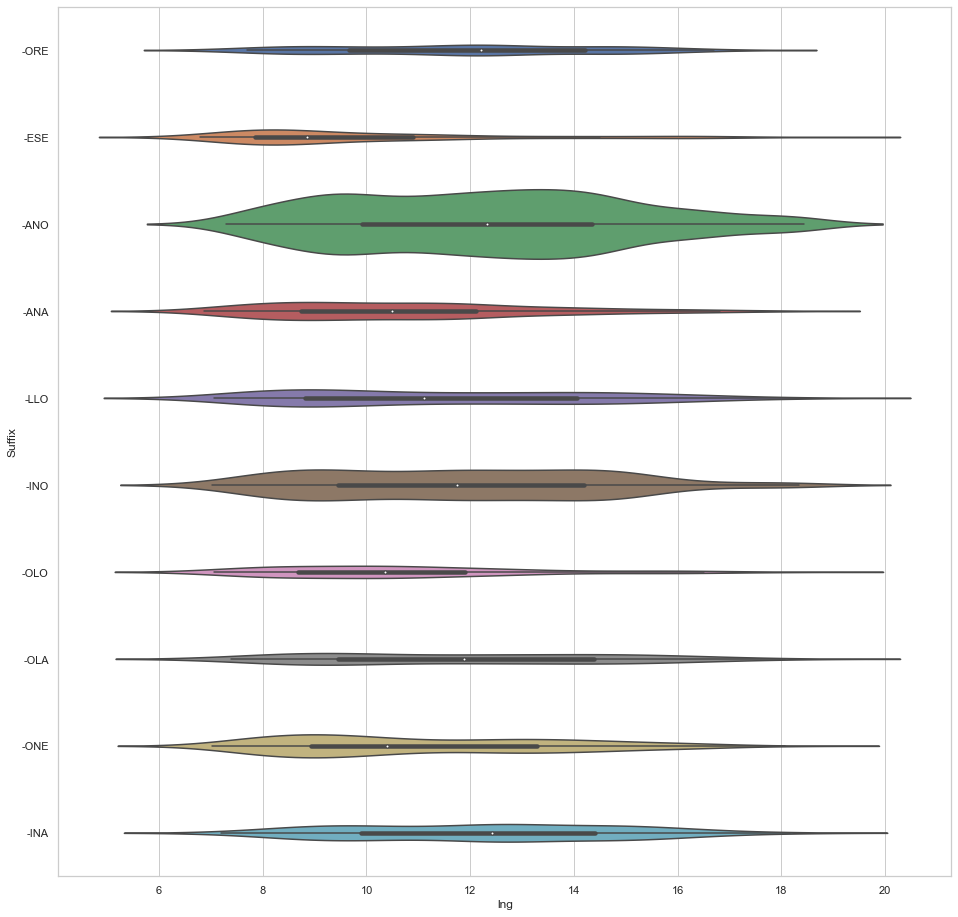

In [19]:
sns.violinplot(x="lng", y="Suffix", scale="count", orient="h", data=df_suf)

### Looking for most frequent endings by region

In [20]:
df_new = pd.DataFrame({'count' : df.groupby( ["region", "Suffix"] ).size()}).reset_index()

df_sorted = df_new.sort_values(by=["region", "count"], ascending=[True, False])
df_sorted.reset_index(drop=True, inplace=True)
df_sorted = df_sorted.groupby("region").head(3).reset_index(drop=True)
df_sorted

region Suffix  count
0                 Abruzzo   -ANO     27
1                 Abruzzo   -INO     15
2                 Abruzzo   -OLI     15
3              Basilicata   -ANO     17
4              Basilicata   -ICO      6
5              Basilicata   -LLA      6
6                Calabria   -ANO     28
7                Calabria   -ETO     10
8                Calabria   -INA     10
9                Campania   -ANO     76
10               Campania   -INO     30
11               Campania   -INA     16
12         Emilia-Romagna   -ANO     34
13         Emilia-Romagna   -OLA     13
14         Emilia-Romagna   -LIA     11
15  Friuli-Venezia Giulia   -ANO     17
16  Friuli-Venezia Giulia   -CCO     10
17  Friuli-Venezia Giulia   -ULI     10
18                  Lazio   -ANO     68
19                  Lazio   -INO     26
20                  Lazio   -INA     22
21                Liguria   -URE     14
22                Liguria   -ANO     10
23                Liguria   -ONE      9
24              Lombardia   -ANO    112
25              Lombardia   -ATE     79
26              Lombardia   -AGO     57
27                 Marche   -ANO     32
28                 Marche   -ONE     12
29                 Marche   -INO     10
30                 Molise   -ANO     13
31                 Molise   -NIO      8
32                 Molise   -ONE      7
33               Piemonte   -ESE     66
34               Piemonte   -ANO     59
35               Piemonte   -ONE     47
36                 Puglia   -ANO     44
37                 Puglia   -INO     17
38                 Puglia   -LIA     10
39               Sardegna   -ANA      9
40               Sardegna   -INI      8
41               Sardegna   -ARA      6
42                Sicilia   -INA     16
43                Sicilia   -LIA     13
44                Sicilia   -INO     10
45                Toscana   -ANO     38
46                Toscana   -ANA     17
47                Toscana   -INA     10
48    Trentino-Alto Adige   -ANO     18
49    Trentino-Alto Adige   -ANA     12
50    Trentino-Alto Adige   -ENA      9
51                 Umbria   -ANO      9
52                 Umbria   -ONE      7
53                 Umbria   -ETO      5
54          Valle d'Aosta   -CHE      3
55          Valle d'Aosta   -GNE      3
56          Valle d'Aosta   -EIN      2
57                 Veneto   -ANO     34
58                 Veneto   -INO     32
59                 Veneto   -ORE     29

In [21]:
df_so = pd.pivot_table(df_sorted, columns="region", values="count", index="Suffix", fill_value=0)
df_so

region  Abruzzo  Basilicata  Calabria  Campania  Emilia-Romagna  \
Suffix                                                            
-AGO          0           0         0         0               0   
-ANA          0           0         0         0               0   
-ANO         27          17        28        76              34   
-ARA          0           0         0         0               0   
-ATE          0           0         0         0               0   
-CCO          0           0         0         0               0   
-CHE          0           0         0         0               0   
-EIN          0           0         0         0               0   
-ENA          0           0         0         0               0   
-ESE          0           0         0         0               0   
-ETO          0           0        10         0               0   
-GNE          0           0         0         0               0   
-ICO          0           6         0         0               0   
-INA          0           0        10        16               0   
-INI          0           0         0         0               0   
-INO         15           0         0        30               0   
-LIA          0           0         0         0              11   
-LLA          0           6         0         0               0   
-NIO          0           0         0         0               0   
-OLA          0           0         0         0              13   
-OLI         15           0         0         0               0   
-ONE          0           0         0         0               0   
-ORE          0           0         0         0               0   
-ULI          0           0         0         0               0   
-URE          0           0         0         0               0   

region  Friuli-Venezia Giulia  Lazio  Liguria  Lombardia  Marche  Molise  \
Suffix                                                                     
-AGO                        0      0        0         57       0       0   
-ANA                        0      0        0          0       0       0   
-ANO                       17     68       10        112      32      13   
-ARA                        0      0        0          0       0       0   
-ATE                        0      0        0         79       0       0   
-CCO                       10      0        0          0       0       0   
-CHE                        0      0        0          0       0       0   
-EIN                        0      0        0          0       0       0   
-ENA                        0      0        0          0       0       0   
-ESE                        0      0        0          0       0       0   
-ETO                        0      0        0          0       0       0   
-GNE                        0      0        0          0       0       0   
-ICO                        0      0        0          0       0       0   
-INA                        0     22        0          0       0       0   
-INI                        0      0        0          0       0       0   
-INO                        0     26        0          0      10       0   
-LIA                        0      0        0          0       0       0   
-LLA                        0      0        0          0       0       0   
-NIO                        0      0        0          0       0       8   
-OLA                        0      0        0          0       0       0   
-OLI                        0      0        0          0       0       0   
-ONE                        0      0        9          0      12       7   
-ORE                        0      0        0          0       0       0   
-ULI                       10      0        0          0       0       0   
-URE                        0      0       14          0       0       0   

region  Piemonte  Puglia  Sardegna  Sicilia  Toscana  Trentino-Alto Adige  \
Suffix                                                      

In [22]:
df_so["Total"] = df_so.sum(axis=1)
df_so.sort_values(by="Total", ascending=False, inplace=True)
df_so.drop(columns=["Total"], inplace=True)

<AxesSubplot:title={'center':'Top town name endings in Italy'}, ylabel='Suffix'>

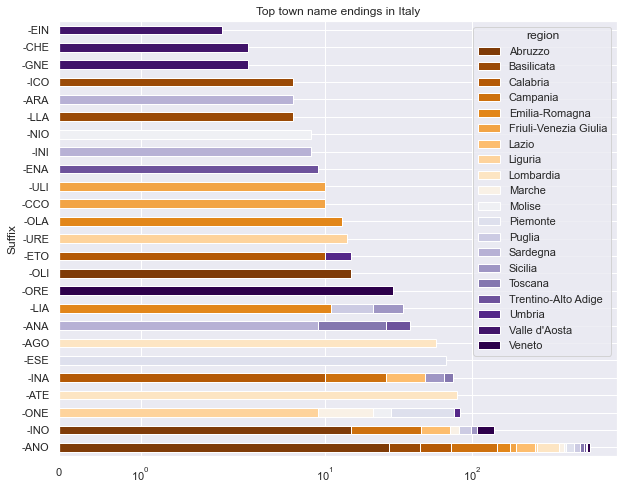

In [37]:
sns.set(rc={'figure.figsize':(10,8)})
df_so.plot(kind="barh", title="Top town name endings in Italy", colormap="PuOr", stacked=True, logx="sym")